# Homework -- Sequential Learning

Pierre Gaillard -- Jan. 2025


# Part 1. Porfolio Selection



The objective of this homework is to implement from scratch several algorithms from the class to select a portfolio. 
Given an initial capital $\mathrm{Cap}_0 > 0$, a trader repeatedly distributes her capital over $d$ assets with the goal of maximizing the total return. At each round $t=1,\dots, T$, the trader chooses an allocation $w_t \in \Delta_d:= \{\theta \in \mathbb{R}^d_+, \|\theta\|_1 = 1\}$. Here, $w_t(i)$ represents the share of capital invested into asset $i \in [d]$ at this round. At the end of the round, the returns (the ratios of the closing and opening prices of all assets in this round) are revealed in the form of $r_t \in \mathbb{R}^d_+$ and the trader's capital is updated as
$$
    \mathrm{Cap}_t = \mathrm{Cap}_{t-1} \langle w_t, r_t \rangle \,.
$$
The performance of a strategy that selected portfolios $(w_t)$ is quantified by comparing the final capital $\mathrm{Cap}_T$ against
$$
    \mathrm{Cap}_T^* =  \mathrm{Cap}_0 \max_{w \in \Delta_d} \prod_{t=1}^T \langle w, r_t\rangle \,,
$$
the idealized final capital attained by the best static strategy constrained to select the same rebalanced portfolio in all rounds. Due to the multiplicative structure, to maximize the capital it is natural to maximize the ratio $\mathrm{Cap}_T/ \mathrm{Cap}_T^*$, which is equivalent to minimizing the regret
$$
    \mathrm{Reg}_T := \sum_{t=1}^T \ell_t(w_t) - \min_{w \in \Delta_d} \sum_{t=1}^T \ell_t(w) = - \log \frac{\mathrm{Cap}_T}{\mathrm{Cap}_T^*} \,,
$$
where $\ell_t(w) := - \log \langle w, r_t\rangle$. In the following, we assume that the trader starts with $\mathrm{Cap}_0 = \$1$.


## Datasets


The folder `data` contains six datasets from financial markets: Dow Jones (DJIA), Morgan Stanley Capital International (MSCI), New York Stock Exchange (NYSE), Standard \& Poor's 500 Index (S\&P 500), and Toronto Stock Exchange (TSE). In these datasets, each row corresponds to a vector of price ratios, denoted as $r_t$. In other words, if $x$ dollars are invested in asset $k$ on day $t$, the trader's capital is updated to $x \cdot r_t(k)$.

| Dataset    | Region | Time Frame                          | # Periods | # Assets |
|------------|--------|--------------------------------------|-----------|----------|
| NYSE (O)   | USA    | July 3, 1962 – December 31, 1984    | 5651      | 36       |
| NYSE (N)   | USA    | January 1, 1985 – June 30, 2010     | 6431      | 23       |
| TSE        | CA     | January 4, 1994 – December 31, 1998 | 1259      | 88       |
| SP500      | USA    | January 2, 1998 – January 31, 2003  | 1276      | 25       |
| MSCI       | Global | April 1, 2006 – March 31, 2010      | 1043      | 24       |
| DJIA       | USA    | January 14, 2001 – January 14, 2003 | 507       | 30       |



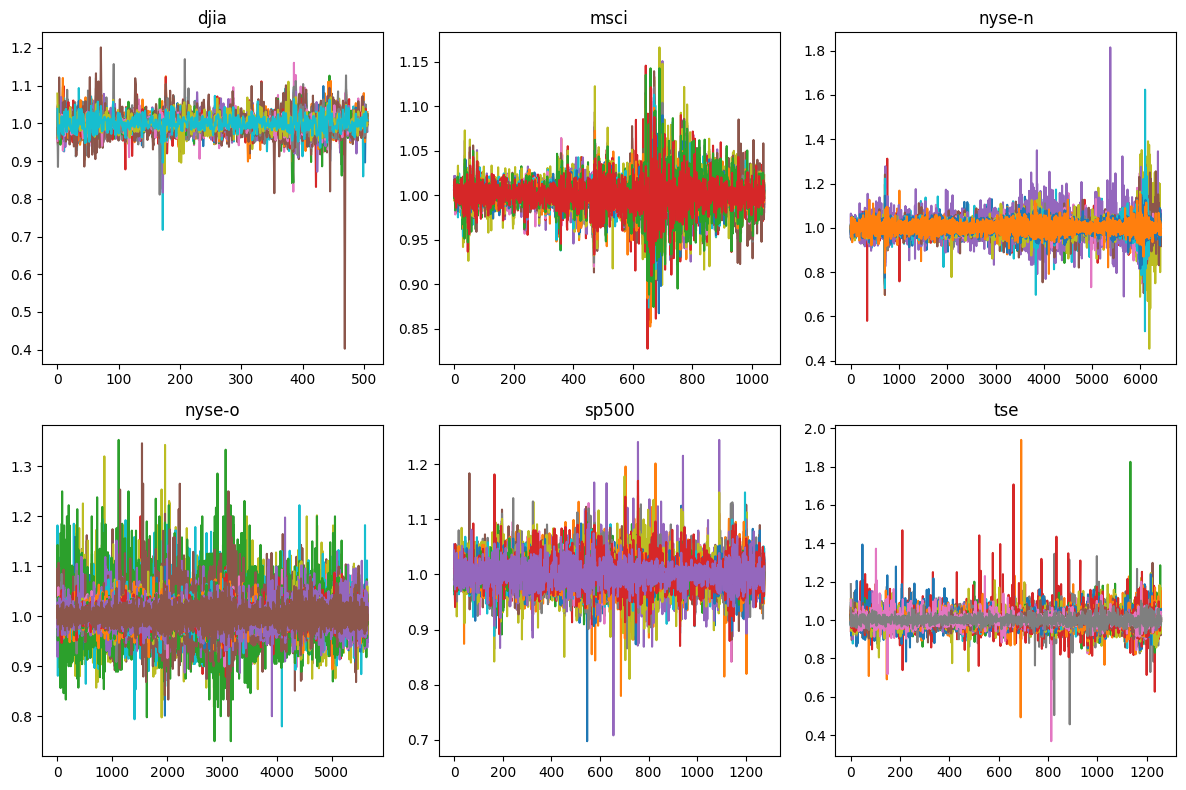

In [17]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Load data
data_names = ["djia","msci","nyse-n","nyse-o","sp500","tse"]
data = {}

fig, axes = plt.subplots(2, 3, figsize=(12, 8))  # 2 rows, 3 columns
axes = axes.flatten()
for i in range(6):
    name = data_names[i]
    data[name] = pd.read_csv("data/"+name+".csv",header = None) 
    axes[i].plot(data[name]) 
    axes[i].set_title(name)
plt.tight_layout()
plt.show()

### Question 1

Display a table that shows for each dataset:
* the final capital $\max_{k} \prod_{t=1}^T r_t(k)$ obtained by the trader if she had chosen the best fixed asset;
* the final capital $\mathrm{Cap_T^*}$ obtained by the trader if she had chosen the best fixed rebalanced portfolio (you may use convex optimisation libraries).

In [16]:
data_names = ["djia","msci","nyse-n","nyse-o","sp500","tse"]
for i in range(6):
    name = data_names[i]
    dataset = pd.read_csv("data/"+name+".csv",header = None) 
    print(f"Total NaN for dataset {name}:", dataset.isna().sum().sum())

Total NaN for dataset djia: 0
Total NaN for dataset msci: 0
Total NaN for dataset nyse-n: 0
Total NaN for dataset nyse-o: 0
Total NaN for dataset sp500: 0
Total NaN for dataset tse: 0


The optimization consists in : $w^* = \text{argmax} \prod _{t=1} ^{T} w^{T} r_t$ such that $w \geq 0$ and $ \sum w_i = 1$.

In [61]:
import cvxpy as cp  # convec optimisation library

data_names = ["djia","msci","nyse-n","nyse-o","sp500","tse"]
best_fixed_asset_capital = []
best_fixed_rebalanced_portfolio = []

for i in range(6):
    name = data_names[i]
    dataset = pd.read_csv("data/"+name+".csv",header = None) 
    k, T = dataset.shape
    dataset1 = dataset.copy()
    dataset2 = dataset.copy()
    # First part of the question
    dataset1["final_capital"] = dataset1.prod(axis=1)
    best_fixed_asset_capital.append(dataset1["final_capital"].max())
    # Second part of the question
    w = cp.Variable(k)  
    constraints = [cp.sum(w) == 1, w >= 0]
    dataset2 = dataset2.cumprod(axis=1)
    R = dataset2.to_numpy().T
    objective = cp.Maximize(cp.sum(cp.log(R @ w)))
    problem = cp.Problem(objective=objective, constraints=constraints)
    problem.solve()
    w_star = w.value
    best_fixed_rebalanced_portfolio.append(np.sum(R @ w_star))

df = pd.DataFrame(
    index=data_names, 
    columns=["best_fixed_asset_capital", "best_fixed_rebalanced_portfolio"], 
    data=list(zip(best_fixed_asset_capital, best_fixed_rebalanced_portfolio))
)
df

,best_fixed_asset_capital,best_fixed_rebalanced_portfolio
djia,6.430887,93.028267
msci,6.706020,74.357196
nyse-n,11.605804,108.005891
nyse-o,9.262229,146.421843
sp500,4.163038,59.725282
tse,25.505519,755.677949


### Question 2
Implement the update rule of the exponentially weighted average algorithm, that takes the current weight vector $w_t$, the vector $r_r$ and a learning rate and return the new weight vector.

In [ ]:
def EWA_update(eta, p, r):
  # eta: learning rate
  # p: an np.array of shape (d,); vector of weights in Delta_d; to be updated
  # r: an np.array of shape (d,); vector of price ratios
  # Returns: an np.array of shape (d,); 

  # ---
  # ADD YOUR CODE HERE
  # ---

  return

### Question 3 - EWA

Use EWA_update to select you portfolio sequentially.

In [ ]:
# Set a learning rate
eta = 1
capital_ewa = {}

for name in data_names:
    T, d = data[name].shape
    capital_ewa[name] = 1
    
    # Initialize the weights
    w = np.full(d, 1/d)

    for day in range(T):
        # Update capital
        capital_ewa[name] = None # TODO
        # Update the weight vector to redistribute the capital for the next day
        w =  None # TODO
    
display(capital_ewa)

### Question 4

a) What is the best theoretical value for eta ? 

b) Plot for the `djia` dataset the evolution of the weights for the theoretical value of eta and a well-chosen value (tuned by hand to minimize the final error).


### Question 5 -- EG
Repeat questions 3 and 4 by using the gradient of the loss (i.e., by using EG) instead of the loss vectors of the experts directly. 

### Question 6 - Projection on the unit simplex

Here is a simple algorithm to implement (Source at the end of the document).

Let $x=\big(x(i)\big)\in\mathbb{R}^M$,
- Sort the coordinates of x into $y_1\geq y_2\geq\dots\geq y_M$,
- Find
$$ \rho=\max\Big\{j\in 1,\dots,M:\ y_j-\frac{1}{j}\big(\sum_{r=1}^jy_r-1\big)>0\Big\},$$
- Define $z = \frac{1}{\rho}\big(\sum_{r=1}^\rho y_r-1\big)$,
- Return, for all $i=1, \dots,M$
$$\big(\Pi_{\Delta_M}(x)\big)(i) = \max\big\{x(i)-z, 0\big\}$$

Define the projection function.



In [ ]:
# Projection on the simplex.
def proj_simplex(w):
  # w: vector in R^d
  # Returns: a vector in Delta_d

  # ---
  # ADD YOUR CODE HERE
  # ---
  return

### Question 7 - OGD
Implement the update rule of the Online Gradient Descent algorithm, that take the current weight vector $w_t$, the gradientof $g_t$ and a learning rate and return the new weight vector.

In [ ]:
def OGD_update(eta, w, r):
  # eta: learning rate
  # w: an np.array of shape (d,); vector of weights in Delta_d; to be updated
  # r: an np.array of shape (d,); price ratio
  # Returns: an np.array of shape (d,); 

  # ---
  # ADD YOUR CODE HERE
  # ---
  return

### Question 8 
Repeat questions 3 and 4 with OGD.

### Question 9
Test better solutions to tune the learning rate in practice for OGD. Ideas: use $\eta_t = \sqrt{1/\sum_{s=1}^t \|g_s\|^2}$ for OGD, where $g_s$ is the gradient at time $s$, or define a grid of possible learning rate and use at time $t$ the learning rate that performed the best until round $t-1$.

### Question 10 
What particular curvature property has the loss function here. What would be the regret of ONS compared to OGD or EG?

### Question 11 (optional)
Repeat questions 3 and 4 with ONS or OMD with a custom regularization function (you may use convex optimization library to compute the update of the algorithm or the projection). 

### Question 12
Print a table summarizing the final capital obtained by the best asset, the best fixed rebalanced portfolio, and the different algorithms (each for the best learning rate tuned on data and the theoretical value).


### Question 13 (optional) -- Bandit feedback
We now assume that each day, the trader only observes its updated captital at each round $\mathrm{Cap}_{t}$ and has no access to the vectors $r_t$. Implement OGD with no gradient to select your portfolio in this case and display you final capitals. 

# References
- Duchi, J., Shalev-Shwartz, S., Singer, Y., & Chandra, T. (2008, July). Efficient projections onto the l 1-ball for learning in high dimensions. In Proceedings of the 25th international conference on Machine learning (pp. 272-279).